# 어텐션을 이용한 텍스트 요약

In [65]:
# 아마존 리뷰 데이터에 대한 이해
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
np.random.seed(seed=0)

In [66]:
# 데이터 56만개의 샘플 중 10만개의 샘플만 사용
data = pd.read_csv(r'D:\Project-1\study\Reviews.csv', nrows=100000)
print("전체 리뷰 개수:",len(data))

전체 리뷰 개수: 100000


In [67]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [68]:
# Text열이 원문이고, Summary 열이 Text열에 대한 요약
# 모델은 원문으로부터 요약을 예측하도록 훈련됨
data = data[['Text','Summary']]
data.head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


In [69]:
# 랜덤으로 10개 출력
data.sample(10)

,Text,Summary
3582,"I rarely eat anything but whole wheat pasta, b...",reminds me of Italy
60498,I absolutely love 5-hour ENERGY! I use it afte...,5-hour ENERGY Highly Recommend!
53227,"this chocolate is a true treat to eat, perfect...",supreme chocolate
21333,Greenies are very muched loved as a tatsy Trea...,Excellent Teeth Cleaner
3885,I love these noodles. They are really great f...,Great and good price!
51521,These are great! As a lover of all chips I'm s...,"Delicious, just like Salt and Vinegar Chips!"
84261,Like other customers I divide these into handf...,"Great snack, great value"
10685,I recommend this instead for the same price: <...,"It's ok, but certainly not worth the cost"
59948,"The noodles were all very broken, but the tast...",Knorr's beef noodles
41032,"Despite claiming they use the ""finest ingredie...",HORRIBLE INGREDIENTS


# 데이터 전처리

In [70]:
# 중복이 있는 지 체크
print("Text열에서 중복을 배제한 유일한 샘플의 수:",data['Text'].nunique())
print("Summary열에서 중복을 배제한 유일한 샘플의 수:",data['Summary'].nunique())

Text열에서 중복을 배제한 유일한 샘플의 수: 88426
Summary열에서 중복을 배제한 유일한 샘플의 수: 72348


In [71]:
# text열에서 중복인 내용이 있다면 중복 제거
data.drop_duplicates(subset=['Text'],inplace=True)
print("전체 샘플수:",len(data))

전체 샘플수: 88426


In [72]:
# 결측치
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [73]:
data.dropna(axis=0,inplace=True)
data.isnull().sum()

Text       0
Summary    0
dtype: int64

In [74]:
# 전체 샘플수
print("전체 샘플수:",len(data))

전체 샘플수: 88425


In [75]:
# NLTK의 불용어
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print("불용어 개수:",len(stop_words))
print(stop_words)

불용어 개수: 179
{'further', 'needn', 'on', 'ours', 'and', 'after', 'so', 'aren', 'no', "didn't", 'wouldn', 'again', 'most', 'which', 'why', 'll', 'mustn', 'doing', 'whom', 'was', 'both', 'that', 'if', 'i', 'all', 'your', 'were', "shan't", 'where', 'isn', 'who', 'how', 'her', "mustn't", 'won', 'these', 'down', "needn't", 'during', 'other', 'hadn', 'she', 'myself', 'before', 'or', 'this', 's', 'off', 'below', "won't", 'our', 'over', 'm', 'through', 'own', 'we', "should've", 'such', 'from', 'ma', "you'll", 'be', 'for', 'wasn', 'y', 'against', "you've", 've', 'same', "mightn't", 'hers', 'out', 'have', 'now', 'because', 'does', 'just', 'don', 'him', "that'll", 'had', "haven't", 'my', 'weren', 'but', 'o', 'their', 'been', 'doesn', 'an', "weren't", 'his', 'can', "shouldn't", 'in', 'until', 'there', 'than', "it's", 'has', 'with', 'under', 'himself', "you're", 'herself', 'when', 'haven', 'mightn', 'is', 'yourself', 'being', 'above', 'hasn', 'should', 'itself', 'here', "she's", 'he', 'shan', 'as', '

In [76]:
# 전처리 함수 내 사용
# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [77]:
# 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence,'lxml').text # <br/>,<a href=...> 등의 html태그 제거
    sentence = re.sub(r'\([^)]*\)','',sentence)  # 괄호로 닫힌 문자열 제거 ex) my husband(and myself) for => my husband for
    sentence = re.sub('"','',sentence) # 쌍따옴표 제거
    sentence = " ".join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # t는 키값
    sentence = re.sub(r"'s\b","",sentence) #소유격 제거 ex) roland's => roland
    sentence = re.sub("[^a-zA-Z]"," ",sentence) #영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}','mm',sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmmmm yeah => umm yeah

    # 불용어 제거(Text)
    if remove_stopwords:
        tokens = " ".join(word for word in sentence.split() if not word in stop_words if len(word)>1) # stop_words에 없는 단어면 join
    # 불용어 미제거(Summary)
    else:
        tokens = " ".join(word for word in sentence.split() if len(word)>1)
    return tokens

# Text열에서는 불용어를 제거하고, Summary열에서는 불용어를 제거하지 않기로 결정

In [78]:
temp_text = "Everything I bought was great, infact I ordered twice and the third ordered was<br/>for my mother and father."
temp_summary = "Great way to start(or finish) the day!!!"
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary,0))

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [79]:
# Text열 전처리
clean_text = []
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))
clean_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [80]:
# Summary 열 전처리
clean_summary=[]
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s,0))
clean_summary[:5]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

In [81]:
data['Text'] = clean_text
data['Summary'] = clean_summary

In [82]:
# 길이가 공백인 샘플은 Null값으로 반환
data.replace('',np.nan,inplace=True)
print(data.isnull().sum())

Text        0
Summary    70
dtype: int64


In [83]:
data.dropna(axis=0,inplace=True)
print("전체 샘플수:",len(data))

전체 샘플수: 88355


텍스트의 최소 길이: 2
텍스트의 최대 길이: 1235
텍스트의 평균 길이: 38.78053307679249
요약의 최소 길이: 1
요약의 최대 길이: 28
요약의 평균 길이: 4.032776866051723


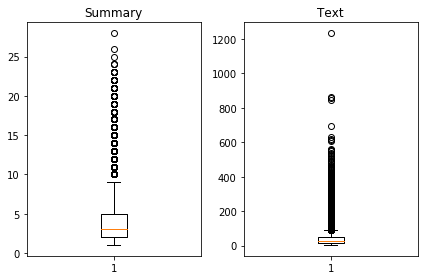

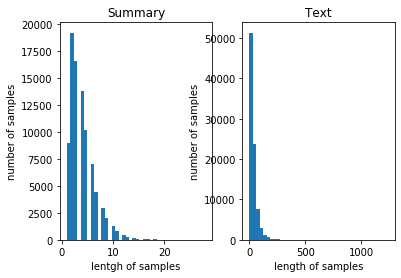

In [84]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print("텍스트의 최소 길이:",np.min(text_len))
print("텍스트의 최대 길이:",np.max(text_len))
print("텍스트의 평균 길이:",np.mean(text_len))
print("요약의 최소 길이:",np.min(summary_len))
print("요약의 최대 길이:",np.max(summary_len))
print("요약의 평균 길이:",np.mean(summary_len))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title("Text")
plt.tight_layout()
plt.show()
plt.subplot(1,2,1)
plt.title('Summary')
plt.hist(summary_len,bins=40)
plt.xlabel("lentgh of samples")
plt.ylabel("number of samples")
plt.subplot(1,2,2)
plt.title('Text')
plt.hist(text_len,bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [85]:
# 패딩길이 정하기
text_max_len = 50
summary_max_len = 8

In [86]:
# 얼마나 많은 샘플들의 길이보다 큰 지 확인
def below_threshold_len(max_len,nested_list):
    cnt = 0
    for s in nested_list:
        if len(s.split())<=max_len:
            cnt = cnt+1
    print("전체 샘플 중 길이가 %s 이하인 샘플들의 비율:%s"%(max_len,(cnt/len(nested_list))))

In [87]:
below_threshold_len(text_max_len,data['Text'])

전체 샘플 중 길이가 50 이하인 샘플들의 비율:0.7746364099371852


In [88]:
below_threshold_len(summary_max_len,data['Summary'])

전체 샘플 중 길이가 8 이하인 샘플들의 비율:0.9400260313508008


In [89]:
# 정해준 최대 길이보다 큰 샘플들은 제거
data = data[data['Text'].apply(lambda x: len(x.split())<=text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split())<=summary_max_len)]
print("전체 샘플수:",len(data))

전체 샘플수: 65693


In [90]:
data.head()

,Text,Summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,confection around centuries light pillowy citr...,delight says it all
3,looking secret ingredient robitussin believe f...,cough medicine
4,great taffy great price wide assortment yummy ...,great taffy


In [91]:
# seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있다. 
# 시작 토큰은 'sostoken', 종료 토큰은 'eostoken'이라 명명
data['decoder_input'] = data['Summary'].apply(lambda x: 'sostoken'+ x)
data['decoder_target'] = data['Summary'].apply(lambda x: x + 'eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostokengood quality dog food,good quality dog foodeostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostokennot as advertised,not as advertisedeostoken
2,confection around centuries light pillowy citr...,delight says it all,sostokendelight says it all,delight says it alleostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostokencough medicine,cough medicineeostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostokengreat taffy,great taffyeostoken


In [92]:
encoder_input = np.array(data['Text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

# 데이터의 분리

In [93]:
from sklearn.model_selection import train_test_split
encoder_input_train, encoder_input_test, decoder_input_train, decoder_input_test, decoder_target_train, decoder_target_test = \
train_test_split(encoder_input, decoder_input, decoder_target, test_size=0.2, shuffle=True)

In [94]:
print(encoder_input_train.shape)
print(encoder_input_test.shape)
print(decoder_input_train.shape)
print(decoder_input_test.shape)
print(decoder_target_train.shape)
print(decoder_target_test.shape)

(52554,)
(13139,)
(52554,)
(13139,)
(52554,)
(13139,)


# 정수 인코딩

In [95]:
# 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩 수행
# 훈련 데이터에 대해서 단어 집합을 만들어보기
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [96]:
# 등장 빈도수 낮은 단어는 제외
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0    # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key,value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    if value < threshold:
        rare_cnt +=1
        rare_freq = rare_freq+value
print("단어 집합의 크기:",total_cnt)
print("등장 빈도가 %s번 이하의 희귀 단어의 수: %s"%(threshold-1,rare_cnt))
print("단어 집합에서 희귀 단어를 제외시킬 경우 단어 집합의 크기: %s"%(total_cnt-rare_cnt))
print("단어 집합에서 희귀 단어의 비율:",(rare_cnt/total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:",(rare_freq/total_freq)*100)

단어 집합의 크기: 31961
등장 빈도가 6번 이하의 희귀 단어의 수: 23774
단어 집합에서 희귀 단어를 제외시킬 경우 단어 집합의 크기: 8187
단어 집합에서 희귀 단어의 비율: 74.38440599480617
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4162399762023807


In [97]:
# 단어사전 크기 8000으로 제한
src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [98]:
print(encoder_input_train[:3])

[[59, 63, 6, 19, 26, 1, 38, 32, 19, 780, 50, 280], [30, 45, 75, 64, 632, 72, 813, 6427, 1067, 84, 237, 86, 336, 19, 51, 331, 1308, 668, 641, 20, 5281, 682, 40, 61, 120, 23, 25, 4921, 214, 173, 449, 709, 16], [24, 853, 6428, 247, 260, 703, 43, 576, 853, 1380, 23, 51, 669, 12, 101, 23, 14, 654, 1112, 3245, 499, 290, 79, 3, 1452, 8, 416, 26, 97, 246, 1, 1033, 2348, 319, 459, 337, 41]]


In [99]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [100]:
threshold=6
total_cnt = len(tar_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key,value in tar_tokenizer.word_counts.items():
    total_freq = total_freq+value

    if value < threshold:
        rare_cnt = rare_cnt +1
        rare_freq = rare_freq+value
print("단어 집합의 크기:",total_cnt)
print("등장 빈도가 %s번 이하의 희귀 단어의 수: %s"%(threshold-1,rare_cnt))
print("단어 집합에서 희귀 단어를 제외시킬 경우 단어 집합의 크기: %s"%(total_cnt-rare_cnt))
print("단어 집합에서 희귀 단어의 비율:",(rare_cnt/total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:",(rare_freq/total_freq)*100)

단어 집합의 크기: 13506
등장 빈도가 5번 이하의 희귀 단어의 수: 10740
단어 집합에서 희귀 단어를 제외시킬 경우 단어 집합의 크기: 2766
단어 집합에서 희귀 단어의 비율: 79.52021323856064
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 9.995973874921713


In [101]:
tar_vocab = 2500
tar_tokenizer = Tokenizer(num_words = tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [102]:
# 텍스트 시퀀스롤 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [103]:
print(decoder_input_train[:5])

[[21, 46], [1760, 422, 490], [2307, 16, 11], [54], [30, 364, 31, 14, 367]]


In [104]:
print(decoder_target_train[:5])

[[937, 21, 97], [1760, 422, 837], [573, 16, 11], [51], [11, 364, 31, 14, 681]]


# 빈 샘플 제거

In [105]:
# 빈도수가 많이 나오는 단어들로 제한을 둠으로써 빈 문장이 생겼을 가능성이 있다.
# 그러나 eos, sos토큰이 포함되어 있으므로 빈 문장의 길이는 1이다
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence)==1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence)==1]

In [106]:
len(drop_train)
len(drop_test)

2155

In [107]:
encoder_input_train = np.delete(encoder_input_train,drop_train,axis=0)
decoder_input_train = np.delete(decoder_input_train,drop_train,axis=0)      # summary
decoder_target_train = np.delete(decoder_target_train,drop_train,axis=0)

encoder_input_test = np.delete(encoder_input_test,drop_test,axis=0)
decoder_input_test = np.delete(decoder_input_test,drop_test,axis=0)
decoder_target_test = np.delete(decoder_target_test,drop_test,axis=0)

In [108]:
print("훈련 데이터의 개수:",len(encoder_input_train))
print("훈련 레이블의 개수:",len(decoder_input_train))
print("테스트 데이터의 개수:",len(encoder_input_test))
print("테스트 레이블의 개수:",len(decoder_input_test))

훈련 데이터의 개수: 43856
훈련 레이블의 개수: 43856
테스트 데이터의 개수: 10984
테스트 레이블의 개수: 10984


# 패딩하기

In [109]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len,padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train,maxlen = summary_max_len,padding='post')
decoder_input_test = pad_sequences(decoder_input_test,maxlen = summary_max_len,padding='post')
decoder_target_train = pad_sequences(decoder_target_train,maxlen = summary_max_len,padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding = 'post')

# seq2seq + attention요약으로 모델 설계 및 훈련시키기

In [110]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [111]:
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs) #src_vocab = 8000

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM2 
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)


In [112]:
# 디코더
# 디코더의 설계는 인코더와 사실상 동일하지만 초기 상태를 인코더의 상태로 주어야 하는 것에 주의
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _,_ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [113]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs],decoder_softmax_outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 128)      1024000     input_7[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 50, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [114]:
# 어텐션 메터니즘 사용할 예정이므로 위에서 설계한 출력층 사용하지 않고, 어텐션 메커니즘이 결합된 새로운 출력층 설계
# 어텐션 함수 작성하지 않고 이미 깃허브에 공개된 함수 사용
# 바다나우 어텐션
urllib.request.urlretrieve('https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py',filename='attention.py')
from attention import AttentionLayer

In [115]:
# 어텐션 매커니즘 이용해서 디코더 출력층 새롭게 설계
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs,decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1,name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs],decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 128)      1024000     input_7[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 50, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [116]:
model.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy')

In [117]:
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1, patience=2)
history = model.fit(x=[encoder_input_train,decoder_input_train],y=decoder_target_train,\
    validation_data=([encoder_input_test, decoder_input_test],decoder_target_test),
    batch_size=256, callbacks=[es],epochs=50)


Train on 43856 samples, validate on 10984 samples
Epoch 1/50
43856/43856 [==============================] - 1470s 34ms/sample - loss: 2.5842 - val_loss: 2.1141
Epoch 2/50
43856/43856 [==============================] - 1411s 32ms/sample - loss: 1.8777 - val_loss: 1.5788
Epoch 3/50
43856/43856 [==============================] - 1453s 33ms/sample - loss: 1.3684 - val_loss: 1.1390
Epoch 4/50
43856/43856 [==============================] - 1513s 35ms/sample - loss: 1.0285 - val_loss: 0.8881
Epoch 5/50
43856/43856 [==============================] - 1532s 35ms/sample - loss: 0.8236 - val_loss: 0.7405
Epoch 6/50
43856/43856 [==============================] - 1570s 36ms/sample - loss: 0.6874 - val_loss: 0.6324
Epoch 7/50
43856/43856 [==============================] - 1548s 35ms/sample - loss: 0.5888 - val_loss: 0.5586
Epoch 8/50
43856/43856 [==============================] - 1548s 35ms/sample - loss: 0.5181 - val_loss: 0.5058
Epoch 9/50
43856/43856 [==============================] - 1549s 35ms/s

In [ ]:
plt.plot(history.history['loss'],label='train')
plt.plot(historh.historh['val_loss'],label='test')
plt.legend()
plt.show()

# seq2seq + attention으로 요약 모델 테스트하기

In [ ]:
src_index_to_word = src_tokenizer.index_word
tag_word_to_index = tar_tokenizer.word_index
tar_index_to_word = tar_tokenizer.index_word

In [ ]:
# seq2seq는 훈련 단계와 테스트 단계의 동작이 다르므로 테스트 단계의 모델을 별도로 다시 설계해줄 필요가 있다.
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

In [ ]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_output2,state_h2, state_c2 = decoder_lstm(dec_emb2,initial_state = [decoder_state_input_h, decoder_state_input_c])